# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py
import obspy
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import torch
from torch.utils.data import DataLoader

# Data

For our purpose the [ComCat](https://github.com/niyiyu/PNW-ML) dataset (62.7 gb) with recorded seimic activity during different explosions and earthquakes will be used. It will be filtered out and proceseed in the next section.


## Process metadata

We assume that the dataset and the metadata is stored in the `data/` folder.

Because seismic data streams are stored in .hdf5 files - we will process the metadata file and then will use the indexes from the metadata to get appropriate streams.

### Step 1. Filter only explosions in the dataset 
As they produces less footprint than earthquakes, we want our model to be more sensetive to minor waves.

In [ ]:
metadata = pd.read_csv("data/full_comcat_metadata.csv")
explosions = metadata[metadata["source_type"] == "explosion"]
explosions = explosions.reset_index(drop=True)

### Step 2. Create train-test split for further model evaluation.

In [ ]:
np.random.seed(42)
test_events = explosions.iloc[[np.random.randint(0, len(explosions)) for _ in range(1000)]].event_id.values.tolist()

In [ ]:
explosions.loc[explosions.event_id.isin(test_events), 'split'] = 'test'
explosions.loc[~explosions.event_id.isin(test_events), 'split'] = 'train'

### Step 3. Save processed metadata file in the same folder with the raw data (.hdf5 file).

In [ ]:
explosions.to_csv("data/metadata.csv", index=False)

## Import data

`data/` folder shoud contain:
- metadata.csv
- waveforms.hdf2

This is predefined format for the `SeisBench` library to work with seismic data.

In [5]:
comcat = sbd.WaveformDataset('data/', component_order='ENZ')
comcat_train = comcat.train()
comcat_test = comcat.test()

2025-05-13 16:28:53,938 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.


## Process the data

In seismology most of the events analyzed based on 2 waveforms: P-waves (faster ones) and S-waves (slower). So the predifined architecture is already set up to train for both wave types prediction. Thus, we will process the data including both wave types in our training dataset.

In the following section the DataLoaders created for the train and test data sets with some augmentations added to the data like slicing different windows within waveforms to give NN more samples to train on, normalizing amptitudes of the waveforms, and automatic labeling based on metadata notation.



To detect the spikes in the seismic wave we will use a predefined model architecture from the `SeisBench` library and will train it on explosion events from our processed dataset, described above, to detect peaks in the seismic waves.

In [6]:
model = sbm.PhaseNet(phases="PSN", norm="peak")

In [7]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S"
}

In [ ]:
comcat_train_generator = sbg.GenericGenerator(dataset=comcat_train)
comcat_test_generator = sbg.GenericGenerator(dataset=comcat_test)

augmentations = [
    # Selects a window of `windowlen` samples around a randomly chosen phase arrival.
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    
    # Selects a random window of `windowlen` samples from the trace.
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    
    # Normalizes the waveform data by removing the mean and scaling by the peak amplitude.
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    
    # Changes the data type of the waveform to np.float32.
    sbg.ChangeDtype(np.float32),
    
    # Creates probabilistic labels for P and S phases based on arrival times.
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model.labels, sigma=10, dim=0)
]

comcat_train_generator.add_augmentations(augmentations)
comcat_test_generator.add_augmentations(augmentations)


In [9]:
batch_size = 256
train_loader = DataLoader(comcat_train_generator, batch_size=batch_size, shuffle=True, worker_init_fn=worker_seeding)
test_loader = DataLoader(comcat_test_generator, batch_size=batch_size, shuffle=False, worker_init_fn=worker_seeding)

# Modeling

Because `SeisBench` library provides models wrapped using pytorch framework - we can train them using the default pytorch approach. So the next section is focused on training predefained architecture from `SeisBench` on the processed data.

In [10]:
# Check available device to run the model
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on MPS")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on MPS


## Define model, optimizer and train&test steps

In [11]:
# Вefine optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)
    h = h.mean()
    return -h

In [ ]:
def train_loop(dataloader, model, device, optimizer, loss_fn):
    """
    Performs one epoch of training.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        model (torch.nn.Module): The model to be trained.
        device (torch.device): The device to run the training on.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        loss_fn (callable): The loss function.
    """
    model.train()
    
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        X, y = batch['X'].to(device, dtype=torch.float32), batch['y'].to(device, dtype=torch.float32)
        # 1. Forward pass
        pred = model(X)
        # 2. Compute loss
        loss = loss_fn(pred, y)
        # 3. Zero gradients
        optimizer.zero_grad()
        # 4. Backward pass
        loss.backward()
        # 5. Update weights
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, device, loss_fn):
    """
    Evaluates the model on the test dataset.

    Args:
        dataloader (torch.utils.data.DataLoader): DataLoader for the test data.
        model (torch.nn.Module): The model to be evaluated.
        device (torch.device): The device to run the evaluation on.
        loss_fn (callable): The loss function.
    """
    model.eval()
    
    num_batches = len(dataloader)
    test_loss = 0

    with torch.inference_mode():
        for batch in dataloader:
            X, y = batch['X'].to(device, dtype=torch.float32), batch['y'].to(device, dtype=torch.float32)
            # 1. Forward pass
            pred = model(X)
            # 2. Compute loss
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

## Run the training

In [21]:
epochs = 50
model.to(device)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, device, optimizer, loss_fn)
    test_loop(test_loader, model, device, loss_fn)

Epoch 1
-------------------------------
loss: 0.627010  [    0/12810]
loss: 0.600572  [ 1280/12810]
loss: 0.574056  [ 2560/12810]
loss: 0.554309  [ 3840/12810]
loss: 0.529960  [ 5120/12810]
loss: 0.510797  [ 6400/12810]
loss: 0.491071  [ 7680/12810]
loss: 0.471676  [ 8960/12810]
loss: 0.454068  [10240/12810]
loss: 0.437930  [11520/12810]
loss: 0.421740  [  500/12810]
Test avg loss: 0.415545 

Epoch 2
-------------------------------
loss: 0.417129  [    0/12810]
loss: 0.401576  [ 1280/12810]
loss: 0.386313  [ 2560/12810]
loss: 0.372155  [ 3840/12810]
loss: 0.357782  [ 5120/12810]
loss: 0.345382  [ 6400/12810]
loss: 0.333852  [ 7680/12810]
loss: 0.321178  [ 8960/12810]
loss: 0.309188  [10240/12810]
loss: 0.297421  [11520/12810]
loss: 0.290650  [  500/12810]
Test avg loss: 0.286251 

Epoch 3
-------------------------------
loss: 0.285369  [    0/12810]
loss: 0.275783  [ 1280/12810]
loss: 0.267273  [ 2560/12810]
loss: 0.256861  [ 3840/12810]
loss: 0.248965  [ 5120/12810]
loss: 0.239302  [ 

KeyboardInterrupt: 

# Testing

In [22]:
# Read the raw data and metadata
explosions = pd.read_csv("data/metadata.csv")
f = h5py.File("data/waveforms.hdf5", "r")


In [ ]:
# Define some helper functions
def process_wave(datafile, metadata, index):
    """
    Processes waveform data and constructs an ObsPy Stream object.

    Args:
        datafile (h5py.file): HDF5 file containing waveform data.
        metadata (pd.DataFrame): Metadata DataFrame containing event and station information.
        index (int): Index of the metadata row to process.

    Returns:
        Tuple[obspy.Stream, pd.Timestamp, pd.Timestamp]:
            - ObsPy Stream object containing waveform traces.
            - Timestamp for the P arrival time.
            - Timestamp for the S arrival time.
    """
    net = metadata.loc[index, 'station_network_code']
    sta = metadata.loc[index, 'station_code']
    sample_p = metadata.loc[index, 'trace_P_arrival_sample']
    sample_s = metadata.loc[index, 'trace_S_arrival_sample']
    sta_loc = metadata.loc[index, 'station_location_code']
    trace_starttime = metadata.loc[index, 'trace_start_time']
    sample_rate = metadata.loc[index, 'trace_sampling_rate_hz']
    source_lat = metadata.loc[index, 'source_latitude_deg']
    source_lon = metadata.loc[index, 'source_longitude_deg']
    sta_lat = metadata.loc[index, 'station_latitude_deg']
    sta_lon = metadata.loc[index, 'station_longitude_deg']
    actual_p = pd.to_datetime(trace_starttime) + pd.to_timedelta(sample_p/sample_rate, unit='s')
    actual_s = pd.to_datetime(trace_starttime) + pd.to_timedelta(sample_s/sample_rate, unit='s')

    tn = metadata.loc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, _, _ = iter([int(i) for i in narray.split(',:')])
    data = datafile['/data/%s' % bucket][x, :, :]

    channels = [
        'E',
        'N',
        'Z'
    ]

    stream = obspy.Stream()
    for i, c in enumerate(channels):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.distance = gps2dist_azimuth(source_lat, source_lon, sta_lat, sta_lon)[0]
        tr.stats.network = net
        tr.stats.sampling_rate = sample_rate
        tr.stats.starttime = UTCDateTime(trace_starttime)
        tr.stats.station = sta
        tr.stats.location = sta_loc
        tr.stats.channel = c

        stream.append(tr)


    return stream, actual_p, actual_s

def get_maximum_confidence_picks(classification):
    """
    Retrieves the picks with the highest confidence (peak value) for P and S phases.

    Args:
        classification: An object containing a list of picks with their associated
                        phase and peak value. Assumes `classification.picks` is iterable
                        and contains objects with `phase` and `peak_value` attributes.

    Returns:
        Tuple[Optional[Pick], Optional[Pick]]:
            - The pick with the highest confidence for the P phase (or None if no P picks are found).
            - The pick with the highest confidence for the S phase (or None if no S picks are found).
    """
    current_maxP_value = 0
    current_maxS_value = 0
    p_max = None
    s_max = None

    for pick in classification.picks:
        if pick.phase == "P":
            if pick.peak_value > current_maxP_value:
                current_maxP_value = pick.peak_value
                p_max = pick
        if pick.phase == "S":
            if pick.peak_value > current_maxS_value:
                current_maxS_value = pick.peak_value
                s_max = pick

    return p_max, s_max


def plot_probabilities(model, stream):
    """
    Plots waveform amplitudes and corresponding probabilities from a model.

    Args:
        model (Any): The model object with an `annotate` method that takes an
                     ObsPy Stream and returns annotations.
        stream (obspy.Stream): The ObsPy Stream containing waveform data.

    Returns:
        None: The function generates a plot and does not return any value.
    """
    annotations = model.annotate(stream)

    fig = plt.figure(figsize=(14.3, 8))
    axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

    offset = annotations[0].stats.starttime - stream[0].stats.starttime
    for i in range(3):
        axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel + ' component')
        if annotations[i].stats.channel[-1] != "N":
            axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel + ' wave arrival')

    axs[0].set_ylabel('Amptitude')
    axs[1].set_ylabel('Probability')
    axs[1].set_xlabel('Time (s)')

    axs[0].legend()
    axs[1].legend()

In [33]:
# Select test sample and make the prediction
test_index = 1000

stream, actual_p_time, actual_s_time = process_wave(f, explosions, test_index)
classification = model.classify(stream, P_threshold=0.01, S_threshold=0.01)

In [34]:
# Print the result
predicted_p, predicted_s = get_maximum_confidence_picks(classification)

if predicted_p is None:
    print("No P wave detected")
else:
    print("Actual P wave:", actual_p_time)
    print("Predicte P wave:", predicted_p.peak_time)

print()

if predicted_s is None:
    print("No S wave detected")
else:
    print("Actual S wave:", actual_s_time)
    print("Predicte S wave:", predicted_s.peak_time)

Actual P wave: 2009-06-11 21:35:47.220000+00:00
Predicte P wave: 2009-06-11T21:35:47.290000Z

Actual S wave: 2009-06-11 21:35:58.800000+00:00
Predicte S wave: 2009-06-11T21:35:58.850000Z


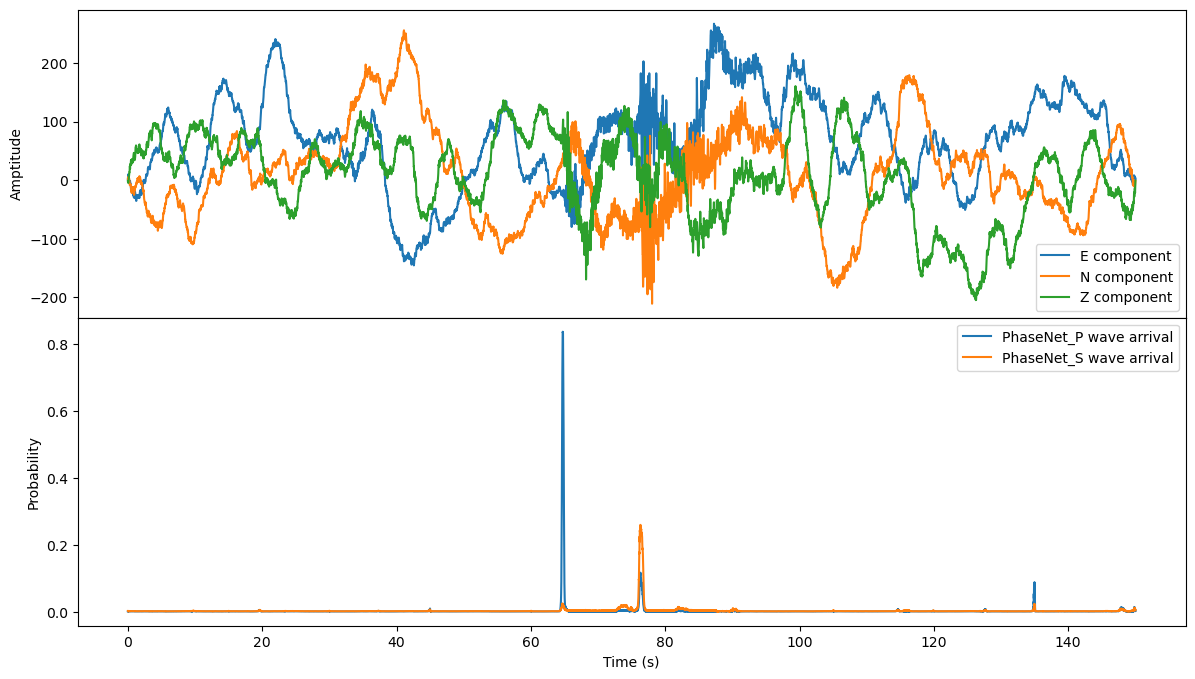

In [35]:
# Visualize the result
plot_probabilities(model, stream)

# Save the model

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), 'output/phasenet_weights.pth')

# Conclusion


This notebook covers data pre-processing, model configuration and training, and processing and visualising the output probabilities.

The model can now predict the P-wave arrival time for each waveform. This is an important part of the project. We can now define the arrival times of the P- and S-waves at every seismic station, and, based on their locations and the difference in arrival times of the waves, we can calculate the location of the source event.